In [1]:
## Load Python libraries

import datetime as dt
import pandas as pd

from wmfdata import hive

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

**POTENTIAL FIXME:** Install Mikhail's ggplot theme and try out using that for the graphs.

In [3]:
%%R
library(ggplot2);
library(data.table);
library(zoo);
library(tidyr);
library(RColorBrewer);

/home/nettrom/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: data.table 1.11.8  Latest news: r-datatable.com

  warnings.warn(x, RRuntimeWarning)
/home/nettrom/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘zoo’


  warnings.warn(x, RRuntimeWarning)
/home/nettrom/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


  warnings.warn(x, RRuntimeWarning)


In [4]:
## Some configuration:
## The wikis we're grabbing data for, start and end dates, and the data lake snapshot we'll use

wikis = ['enwiki', 'itwiki', 'frwiki', 'eswiki']

## Dates that we will use to make plots, they'll show from start date and up to,
## but not including, the end date
start_display_date = dt.date(2014, 1, 1)
end_display_date = dt.date(2019, 5, 1)

## We'll gather data from a year prior to the start date so we can have a yearly running
## average across the whole graph
start_data_date = dt.date(start_display_date.year - 1,
                          start_display_date.month,
                          start_display_date.day)
end_data_date = end_display_date

## Some statistics require a 28-day period, so in those cases we'll truncate to the previous
## month, which we can get at with some date math (assuming that end_display_date is the
## first of the month):
truncated_end_date = (end_display_date - dt.timedelta(days = 1)).replace(day = 1)

## The name of the database snapshot we're using, which should be the year and month
## of the truncated end date
snapshot = "{}".format(truncated_end_date.strftime("%Y-%m"))

## Because rpy2 doesn't convert datetime.date objects, we'll make the display dates
## strings to help with that:
start_display_date_str = str(start_display_date)
end_display_date_str = str(end_display_date)
truncated_end_date_str = str(truncated_end_date)

## Filenames/paths to datasets that can be shared
sitewide_filename = "public_datasets/sitewide_blocks.tsv"
sitewide_nonindefinite_filename = "public_datasets/sitewide_non-indefinite_blocks.tsv"
sitewide_expired_filename = "public_datasets/sitewide_expired_blocks.tsv"
sitewide_expired_noreblock_filename = "public_datasets/sitewide_expired_not-reblocked.tsv"
sitewide_expired_nonreverted_filename = "public_datasets/sitewide_expired_non-reverted.tsv"
sitewide_expired_nonreverted_ns0_filename = "public_datasets/sitewide_expired_non-reverted_ns0.tsv"

def to_tsv(df, output_file):
    df.to_csv(output_file, sep='\t', index=False)

## TODO

I presented on this in the January CHI monthly meeting, and got suggestions to do some follow-up work:

1. Do we know if the users had ever made productive edits before they got blocked?
2. Constructive edits are currently measured across all namespaces. Create another graph where we only count constructive edits to articles. (This is **done!**)

During discussions about this work, I also noticed a need for updating the graphs as follows:

1. Split them out by wiki.
2. Add trend lines, such as 3-month and 12-month moving averages.

## ALSO TODO

Update the queries so that they ignore partial blocks, we need to use the block parameters to identify those.

## A. Number of sitewide blocks

The first measurement is the number of sitewide blocks per month.

**POTENTIAL FIXME:** This can be rewritten to select all block-related events, then use the `lag` function to get the block/unblock status of the previous event, and use that to filter out all reblock events (both current and previous event is a block and the timestamps match). That removes the need for the join. It'll require a sub-query to add the lagged column, but the surrounding query should be quite readable.

In [5]:
sitewide_query = '''
SELECT h1.wiki_db,
       DATE_FORMAT(h1.start_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (
    SELECT * FROM wmf.mediawiki_user_history
    WHERE snapshot = "{snapshot}"
    AND start_timestamp BETWEEN "{start_date}" AND "{end_date}"
    AND wiki_db IN ({wikis})
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) AS h1
LEFT JOIN (
    SELECT * FROM wmf.mediawiki_user_history
    WHERE snapshot = "{snapshot}"
    AND end_timestamp BETWEEN "{start_date}" AND "{end_date}"
    AND wiki_db IN ({wikis})
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) AS h2
ON (h1.wiki_db = h2.wiki_db
    AND h1.user_id = h2.user_id
    AND h1.start_timestamp = h2.end_timestamp)
WHERE h2.start_timestamp IS NULL
GROUP BY h1.wiki_db, DATE_FORMAT(h1.start_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_blocks = hive.run(sitewide_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = end_data_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis])))

In [6]:
sitewide_blocks.head()

,wiki_db,log_month,num_blocks
0,enwiki,2013-01-01,6437
1,enwiki,2013-02-01,6128
2,enwiki,2013-03-01,6401
3,enwiki,2013-04-01,6463
4,enwiki,2013-05-01,6624


In [7]:
## Export the dataset as a TSV

to_tsv(sitewide_blocks, sitewide_filename)

/home/nettrom/venv/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


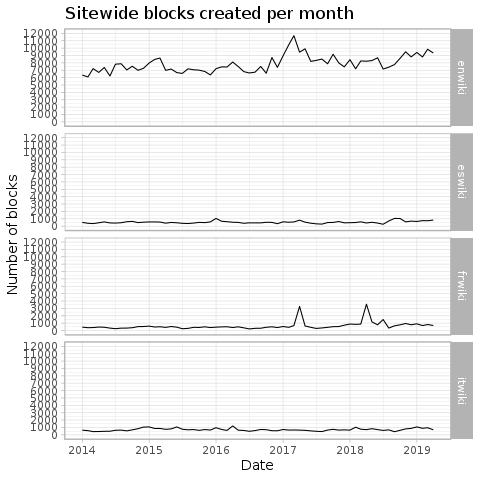

In [8]:
%%R -i sitewide_blocks,start_display_date_str,end_display_date_str

sitewide_blocks = data.table(sitewide_blocks);
sitewide_blocks[, log_month := as.Date(log_month)];

sitewide_block_graph = ggplot(
    sitewide_blocks[log_month >= start_display_date_str &
                    log_month < end_display_date_str],
    aes(x=log_month, y=num_blocks)) +
facet_grid(rows = vars(wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 12000), breaks = c(0:12)*1000) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide blocks created per month',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_blocks_per_month.png",
       plot = sitewide_block_graph, width = 40, height = 80, units = "cm", dpi = "screen");
sitewide_block_graph;

## Showing trends with moving averages

Let's being our exploration of longer-term trends in the data by adding 3-month and 12-month moving averages. If we find that these straigthforward smoothing approaches do not provide us with useful information, we can consider applying more sophisticated ones.

Given that English Wikipedia is so much larger than the other Wikipedias, I find it no longer useful to plot these graphs with ggplot's `facet_grid`. Instead, we'll make a plot for each wiki.

In [9]:
%%R -i sitewide_blocks,start_display_date_str,end_display_date_str

sitewide_blocks = data.table(sitewide_blocks);
sitewide_blocks[, log_month := as.Date(log_month)];

## Add 3-month and 12-month running average
sitewide_blocks[
    , num_blocks_3mma := rollapply(
        num_blocks,
        width = 3,
        FUN = mean,
        na.rm = TRUE,
        fill = 0,
        align = 'right')];
sitewide_blocks[
    , num_blocks_1yma := rollapply(
        num_blocks,
        width = 12,
        FUN = mean,
        na.rm = TRUE,
        fill = 0,
        align = 'right')];

sitewide_blocks_long = sitewide_blocks %>% gather(measure, num_blocks, 3:5);
sitewide_blocks_long = data.table(sitewide_blocks_long);
sitewide_blocks_long[measure == 'num_blocks', measure := 'raw data'];
sitewide_blocks_long[measure == 'num_blocks_3mma', measure := '3-month MA'];
sitewide_blocks_long[measure == 'num_blocks_1yma', measure := '1-year MA'];
sitewide_blocks_long[
    , measure := ordered(measure, rev(c('raw data', '3-month MA', '1-year MA')))];

make_ma_plot = function(dt, wiki, start_date, end_date, title, breaks) {
    b_palette = brewer.pal('Blues', n = 7)[c(3,5,7)];
    ggplot(
        dt[log_month >= start_date &
           log_month < end_date &
           wiki_db == wiki],
        aes(x=log_month, y=num_blocks, colour = measure)) +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    scale_y_continuous(breaks = breaks) +
    expand_limits(y = 0) +
    scale_colour_manual(values = b_palette) +
    labs(title = title,
         x = 'Date',
         y = 'Number of blocks') +
    geom_line() +
    theme_light(base_size = 14);
}

enwiki_sitewide_with_ma_graph = make_ma_plot(
    sitewide_blocks_long, 'enwiki', start_display_date_str, end_display_date_str,
    "Sitewide blocks created per month - English Wikipedia", c(0:12*1000));
ggsave("graphs/sitewide_blocks_per_month_enwiki.png",
       plot = enwiki_sitewide_with_ma_graph, width = 40, height = 20, units = "cm", dpi = "screen");

itwiki_sitewide_with_ma_graph = make_ma_plot(
    sitewide_blocks_long, 'itwiki', start_display_date_str, end_display_date_str,
    "Sitewide blocks created per month - Italian Wikipedia", c(0:12*1000));
ggsave("graphs/sitewide_blocks_per_month_itwiki.png",
       plot = itwiki_sitewide_with_ma_graph, width = 40, height = 20, units = "cm", dpi = "screen");

frwiki_sitewide_with_ma_graph = make_ma_plot(
    sitewide_blocks_long, 'frwiki', start_display_date_str, end_display_date_str,
    "Sitewide blocks created per month - French Wikipedia", c(0:12*1000));
ggsave("graphs/sitewide_blocks_per_month_frwiki.png",
       plot = frwiki_sitewide_with_ma_graph, width = 40, height = 20, units = "cm", dpi = "screen");

eswiki_sitewide_with_ma_graph = make_ma_plot(
    sitewide_blocks_long, 'eswiki', start_display_date_str, end_display_date_str,
    "Sitewide blocks created per month - Spanish Wikipedia", c(0:12*1000));
ggsave("graphs/sitewide_blocks_per_month_eswiki.png",
       plot = eswiki_sitewide_with_ma_graph, width = 40, height = 20, units = "cm", dpi = "screen");


## B. Number of non-indefinite sitewide blocks

This is similar to the previous statistic, but limits it to sitewide blocks that have an expiry timestamp set. To get that, we make a small modification to the previous query. From examining the data, indefinite blocks have `end_timestamp` set to `NULL`, so I'll exclude those.

In [10]:
sitewide_limited_query = '''
SELECT h1.wiki_db,
       DATE_FORMAT(h1.start_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (
    SELECT * FROM wmf.mediawiki_user_history
    WHERE snapshot = "2018-12"
    AND start_timestamp BETWEEN "{start_date}" AND "{end_date}"
    AND wiki_db IN ({wikis})
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) AS h1
LEFT JOIN (
    SELECT * FROM wmf.mediawiki_user_history
    WHERE snapshot = "2018-12"
    AND end_timestamp BETWEEN "{start_date}" AND "{end_date}"
    AND wiki_db IN ({wikis})
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) AS h2
ON (h1.wiki_db = h2.wiki_db
    AND h1.user_id = h2.user_id
    AND h1.start_timestamp = h2.end_timestamp)
WHERE h1.caused_by_block_expiration != "indefinite"
AND h2.start_timestamp IS NULL
GROUP BY h1.wiki_db, DATE_FORMAT(h1.start_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_limited_blocks = hive.run(sitewide_limited_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = end_data_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis])))

In [12]:
sitewide_limited_blocks.head()

,wiki_db,log_month,num_blocks
0,enwiki,2013-01-01,384
1,enwiki,2013-02-01,287
2,enwiki,2013-03-01,333
3,enwiki,2013-04-01,375
4,enwiki,2013-05-01,355


In [13]:
## Export the dataset
to_tsv(sitewide_limited_blocks, sitewide_nonindefinite_filename)

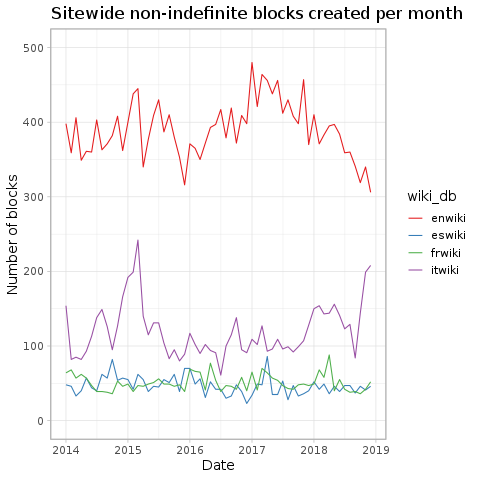

In [14]:
%%R -i sitewide_limited_blocks,start_display_date_str,end_display_date_str

sitewide_limited_blocks = data.table(sitewide_limited_blocks);
sitewide_limited_blocks[, log_month := as.Date(log_month)];

sitewide_limited_block_graph = ggplot(
    sitewide_limited_blocks[log_month >= start_display_date_str &
                            log_month < end_display_date_str],
    aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 500), breaks = c(0:5)*100) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide non-indefinite blocks created per month',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_non-indefinite_blocks_per_month.png",
       plot = sitewide_limited_block_graph, width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_limited_block_graph;

In [15]:
%%R -i sitewide_limited_blocks,start_display_date_str,end_display_date_str

## Let's make plots with moving averages for non-indef blocks as well

sitewide_limited_blocks = data.table(sitewide_limited_blocks);
sitewide_limited_blocks[, log_month := as.Date(log_month)];

## Add 3-month and 12-month running average
sitewide_limited_blocks[
    , num_blocks_3mma := rollapply(
        num_blocks,
        width = 3,
        FUN = mean,
        na.rm = TRUE,
        fill = 0,
        align = 'right')];
sitewide_limited_blocks[
    , num_blocks_1yma := rollapply(
        num_blocks,
        width = 12,
        FUN = mean,
        na.rm = TRUE,
        fill = 0,
        align = 'right')];

sitewide_limited_blocks_long = sitewide_limited_blocks %>% gather(measure, num_blocks, 3:5);
sitewide_limited_blocks_long = data.table(sitewide_limited_blocks_long);
sitewide_limited_blocks_long[measure == 'num_blocks', measure := 'raw data'];
sitewide_limited_blocks_long[measure == 'num_blocks_3mma', measure := '3-month MA'];
sitewide_limited_blocks_long[measure == 'num_blocks_1yma', measure := '1-year MA'];
sitewide_limited_blocks_long[
    , measure := ordered(measure, rev(c('raw data', '3-month MA', '1-year MA')))];

enwiki_sitewide_limited_with_ma_graph = make_ma_plot(
    sitewide_limited_blocks_long, 'enwiki', start_display_date_str, end_display_date_str,
    "Sitewide non-indefinite blocks created per month - English Wikipedia", c(0:12*100));
ggsave("graphs/sitewide_non-indefinite_blocks_per_month_enwiki.png",
       plot = enwiki_sitewide_limited_with_ma_graph, width = 40, height = 20,
       units = "cm", dpi = "screen");

itwiki_sitewide_limited_with_ma_graph = make_ma_plot(
    sitewide_limited_blocks_long, 'itwiki', start_display_date_str, end_display_date_str,
    "Sitewide non-indefinite blocks created per month - Italian Wikipedia", c(0:12*100));
ggsave("graphs/sitewide_non-indefinite_blocks_per_month_itwiki.png",
       plot = itwiki_sitewide_limited_with_ma_graph, width = 40, height = 20,
       units = "cm", dpi = "screen");

frwiki_sitewide_limited_with_ma_graph = make_ma_plot(
    sitewide_limited_blocks_long, 'frwiki', start_display_date_str, end_display_date_str,
    "Sitewide non-indefinite blocks created per month - French Wikipedia", c(0:12*10));
ggsave("graphs/sitewide_non-indefinite_blocks_per_month_frwiki.png",
       plot = frwiki_sitewide_limited_with_ma_graph, width = 40, height = 20,
       units = "cm", dpi = "screen");

eswiki_sitewide_limited_with_ma_graph = make_ma_plot(
    sitewide_limited_blocks_long, 'eswiki', start_display_date_str, end_display_date_str,
    "Sitewide non-indefinite blocks created per month - Spanish Wikipedia", c(0:12*10));
ggsave("graphs/sitewide_non-indefinite_blocks_per_month_eswiki.png",
       plot = eswiki_sitewide_limited_with_ma_graph, width = 40, height = 20,
       units = "cm", dpi = "screen");


In [16]:
%%R

sitewide_limited_blocks_long[wiki_db == 'eswiki']

     wiki_db  log_month   measure num_blocks
  1:  eswiki 2013-01-01  raw data   46.00000
  2:  eswiki 2013-02-01  raw data   47.00000
  3:  eswiki 2013-03-01  raw data   62.00000
  4:  eswiki 2013-04-01  raw data   75.00000
  5:  eswiki 2013-05-01  raw data   69.00000
 ---                                        
212:  eswiki 2018-08-01 1-year MA   42.83333
213:  eswiki 2018-09-01 1-year MA   42.00000
214:  eswiki 2018-10-01 1-year MA   43.08333
215:  eswiki 2018-11-01 1-year MA   43.50000
216:  eswiki 2018-12-01 1-year MA   44.00000


## D. Number of sitewide blocks that expire

This is also similar to the previous queries, but is focused on blocks that reach their expiry timestamp. In this case, it looks like I can identify these by `caused_by_block_expiry` being set to a timestamp (meaning it is not `NULL` nor `indefinite`). One thing to note is that in these events, it's the `end_timestamp` that is the time of when the block expired, while `start_timestamp` is when it was set. So we need to look for matches between the end timestamp and the time of block expiry, those are the events where the block expired without any further action being taken. If a user has their block altered before it expired, the end timestamp is different (typically sooner than) the timestamp set in `caused_by_block_expiration`.

In [20]:
expired_blocks_query = '''
SELECT wiki_db,
       DATE_FORMAT(end_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM wmf.mediawiki_user_history
WHERE snapshot = "{snapshot}"
AND end_timestamp BETWEEN "{start_date}" AND "{end_date}"
AND wiki_db IN ({wikis})
AND caused_by_block_expiration IS NOT NULL
AND caused_by_block_expiration != "indefinite"
AND (unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0")
     = unix_timestamp(caused_by_block_expiration, "yyyyMMddhhmmss"))
GROUP BY wiki_db, DATE_FORMAT(end_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_expired_blocks = hive.run(expired_blocks_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = end_data_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis])))

In [21]:
sitewide_expired_blocks.head()

,wiki_db,log_month,num_blocks
0,enwiki,2016-09-01,377
1,enwiki,2017-04-01,381
2,eswiki,2013-05-01,53
3,frwiki,2015-07-01,66
4,itwiki,2014-05-01,74


In [22]:
## Export the dataset

to_tsv(sitewide_expired_blocks, sitewide_expired_filename)

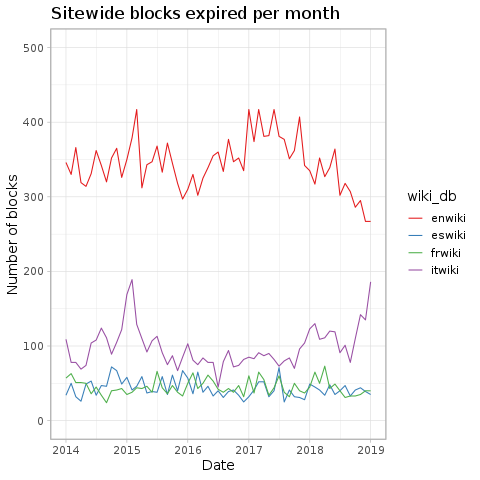

In [31]:
%%R -i sitewide_expired_blocks,start_display_date_str,end_display_date_str

sitewide_expired_blocks = data.table(sitewide_expired_blocks);
sitewide_expired_blocks[, log_month := as.Date(log_month)];

sitewide_expired_blocks_graph = ggplot(
    sitewide_expired_blocks[log_month >= start_display_date_str &
                            log_month < end_display_date_str],
    aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 500), breaks = c(0:5)*100) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide blocks expired per month',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_expired_blocks_per_month.png",
       plot = sitewide_expired_blocks_graph, width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_expired_blocks_graph;

## F. Expired blocks that don't get reblocked

Number of sitewide blocks for users/IPs where the block has an expiry timestamp within the month of interest, and where the user/IP does not receive another sitewide block within 28 days after block expiry.

So this builds on D. I'd prefer to not have to self-join again. Is there a window or something? Yes, there is the `lag` function, WOOHOO!

In [26]:
## How many days need to lapse before the user can be blocked again

days_until_next_block = 28

expired_not_reblocked_query = '''
SELECT wiki_db,
       DATE_FORMAT(end_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (SELECT wiki_db, user_id,
    start_timestamp, end_timestamp,
    caused_by_block_expiration,
    COALESCE(inferred_from, "block") AS block_status,
    COALESCE(LEAD(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp),
        "block") AS next_block_status,
    LEAD(end_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
         AS next_block_end_timestamp
    FROM wmf.mediawiki_user_history
    WHERE snapshot = "{snapshot}"
      AND wiki_db IN ({wikis})
      AND caused_by_event_type = 'alterblocks') AS block_events
WHERE end_timestamp BETWEEN "{start_date}" AND "{end_date}"
AND caused_by_block_expiration IS NOT NULL
AND caused_by_block_expiration != "indefinite"
AND (unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0")
     = unix_timestamp(caused_by_block_expiration, "yyyyMMddhhmmss"))
AND next_block_status = "unblock"
AND (next_block_end_timestamp IS NULL
     OR (unix_timestamp(next_block_end_timestamp, "yyyy-MM-dd hh:mm:ss.0") -
         unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0") > 60*60*24*{ndays}))
GROUP BY wiki_db, DATE_FORMAT(end_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_not_reblocked = hive.run(expired_not_reblocked_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = truncated_end_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis]),
    ndays = days_until_next_block))

In [27]:
sitewide_not_reblocked.head()

,wiki_db,log_month,num_blocks
0,enwiki,2013-01-01,220
1,enwiki,2013-02-01,221
2,enwiki,2013-03-01,211
3,enwiki,2013-04-01,260
4,enwiki,2013-05-01,283


In [28]:
## Export the dataset

to_tsv(sitewide_not_reblocked, sitewide_expired_noreblock_filename)

/home/nettrom/venv/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


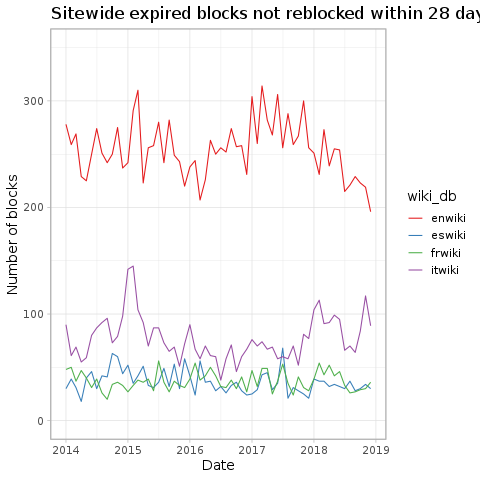

In [33]:
%%R -i sitewide_not_reblocked,start_display_date_str,truncated_end_date_str

sitewide_not_reblocked = data.table(sitewide_not_reblocked);
sitewide_not_reblocked[, log_month := as.Date(log_month)];

sitewide_not_reblocked_graph = ggplot(
    sitewide_not_reblocked[log_month >= start_display_date_str &
                           log_month < truncated_end_date_str],
    aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 350), breaks = c(0:3)*100) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide expired blocks not reblocked within 28 days',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_not_reblocked_28days_per_month.png",
       plot = sitewide_not_reblocked_graph, width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_not_reblocked_graph;

## G. Same as F, but makes >1 non-reverted edit

They have the same 28 day period to make one or more edits. So, we join with the edit history table, and accumulate edits.

It might be tempting to not calculate this, based on the low number of users who do not get reblocked within 28 days. But what we're curious about is the proportion of expired blocks that meet this (and the previous) condition. Both F and G are used in further calculations, with proportions relative to what we measured in section D.

In [42]:
expired_nonreverted_edit_query = '''
SELECT wiki_db,
       DATE_FORMAT(end_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (SELECT wiki_db, user_id, end_timestamp, count(*) AS num_edits
    FROM (SELECT block_events.wiki_db,
          block_events.user_id,
          block_events.end_timestamp
        FROM (SELECT wiki_db,
                     user_id,
                     end_timestamp
            FROM (SELECT wiki_db, user_id,
                start_timestamp, end_timestamp,
                caused_by_block_expiration,
                COALESCE(inferred_from, "block") AS block_status,
                COALESCE(LEAD(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id
                    ORDER BY start_timestamp), "block") AS next_block_status,
                LEAD(end_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
                     AS next_block_end_timestamp
                FROM wmf.mediawiki_user_history
                WHERE snapshot = "{snapshot}"
                  AND wiki_db IN ({wikis})
                  AND caused_by_event_type = 'alterblocks') AS block_events
            WHERE end_timestamp BETWEEN "{start_date}" AND "{end_date}"
            AND caused_by_block_expiration IS NOT NULL
            AND caused_by_block_expiration != "indefinite"
            AND (unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0")
                 = unix_timestamp(caused_by_block_expiration, "yyyyMMddhhmmss"))
            AND next_block_status = "unblock"
            AND (next_block_end_timestamp IS NULL
                 OR (unix_timestamp(next_block_end_timestamp, "yyyy-MM-dd hh:mm:ss.0") -
                     unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0") > 60*60*24*28))
            ) AS block_events
        JOIN (SELECT wiki_db, event_user_id, event_timestamp, event_entity
              FROM wmf.mediawiki_history
              WHERE snapshot = "{snapshot}"
              AND wiki_db IN ({wikis})
              AND event_entity = "revision"
              AND event_type = "create"
              AND event_timestamp > {start_date}
              AND (revision_is_identity_reverted = FALSE
                   OR revision_seconds_to_identity_revert > 60*60*48)
            ) AS revisions
        ON (block_events.wiki_db = revisions.wiki_db
            AND block_events.user_id = revisions.event_user_id)
        WHERE revisions.event_timestamp > block_events.end_timestamp
          AND unix_timestamp(revisions.event_timestamp, "yyyy-MM-dd hh:mm:ss.0") <
              (unix_timestamp(block_events.end_timestamp, "yyyy-MM-dd hh:mm:ss.0") +
               60*60*24*{ndays})
    ) AS post_block_edits
    GROUP BY wiki_db, user_id, end_timestamp
    HAVING count(*) > 0
) AS wiki_user_edits
GROUP BY wiki_db, DATE_FORMAT(end_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_nonreverted_editors = hive.run(expired_nonreverted_edit_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = truncated_end_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis]),
    ndays = days_until_next_block))

In [49]:
expired_nonreverted_edit_query = '''
SELECT wiki_db,
       DATE_FORMAT(end_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (SELECT wiki_db, user_id, end_timestamp, count(*) AS num_edits
    FROM (SELECT block_events.wiki_db,
          block_events.user_id,
          block_events.end_timestamp
        FROM (SELECT wiki_db,
                     user_id,
                     end_timestamp
            FROM (SELECT wiki_db, user_id,
                start_timestamp, end_timestamp,
                caused_by_block_expiration,
                COALESCE(inferred_from, "block") AS block_status,
                COALESCE(LEAD(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id
                    ORDER BY start_timestamp), "block") AS next_block_status,
                LEAD(end_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
                     AS next_block_end_timestamp
                FROM wmf.mediawiki_user_history
                WHERE snapshot = "{snapshot}"
                  AND wiki_db IN ({wikis})
                  AND caused_by_event_type = 'alterblocks') AS block_events
            WHERE end_timestamp BETWEEN "{start_date}" AND "{end_date}"
            AND caused_by_block_expiration IS NOT NULL
            AND caused_by_block_expiration != "indefinite"
            AND (unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0")
                 = unix_timestamp(caused_by_block_expiration, "yyyyMMddhhmmss"))
            AND next_block_status = "unblock"
            AND (next_block_end_timestamp IS NULL
                 OR (unix_timestamp(next_block_end_timestamp, "yyyy-MM-dd hh:mm:ss.0") -
                     unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0") > 60*60*24*28))
            ) AS block_events
        JOIN (SELECT wiki_db, event_user_id, event_timestamp, event_entity
              FROM wmf.mediawiki_history
              WHERE snapshot = "{snapshot}"
              AND wiki_db IN ({wikis})
              AND event_entity = "revision"
              AND event_type = "create"
              AND event_timestamp > "{start_date}"
              AND (revision_is_identity_reverted = FALSE
                   OR revision_seconds_to_identity_revert > 60*60*48)
            ) AS revisions
        ON (block_events.wiki_db = revisions.wiki_db
            AND block_events.user_id = revisions.event_user_id)
        WHERE revisions.event_timestamp > block_events.end_timestamp
          AND unix_timestamp(revisions.event_timestamp, "yyyy-MM-dd hh:mm:ss.0") <
              (unix_timestamp(block_events.end_timestamp, "yyyy-MM-dd hh:mm:ss.0") +
               60*60*24*{ndays})
    ) AS post_block_edits
    GROUP BY wiki_db, user_id, end_timestamp
    HAVING count(*) > 0
) AS wiki_user_edits
GROUP BY wiki_db, DATE_FORMAT(end_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_nonreverted_editors = hive.run(expired_nonreverted_edit_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = truncated_end_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis]),
    ndays = days_until_next_block))

In [50]:
sitewide_nonreverted_editors.head()

,wiki_db,log_month,num_blocks
0,enwiki,2013-01-01,104
1,enwiki,2013-02-01,92
2,enwiki,2013-03-01,90
3,enwiki,2013-04-01,101
4,enwiki,2013-05-01,116


In [51]:
## Export the dataset

to_tsv(sitewide_nonreverted_editors, sitewide_expired_nonreverted_filename)

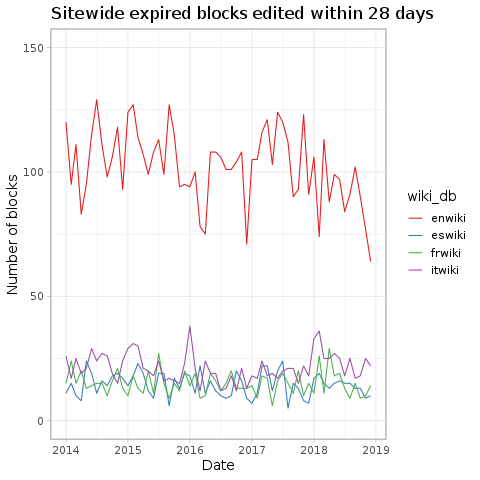

In [52]:
%%R -i sitewide_nonreverted_editors,start_display_date_str,truncated_end_date_str

sitewide_nonreverted_editors = data.table(sitewide_nonreverted_editors);
sitewide_nonreverted_editors[, log_month := as.Date(log_month)];

sitewide_nonreverted_editors_graph = ggplot(
    sitewide_nonreverted_editors[log_month >= start_display_date_str &
                                 log_month < truncated_end_date_str],
    aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 150), breaks = c(0:3)*50) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide expired blocks edited within 28 days',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_nonreverted_editors_28days_per_month.png",
       plot = sitewide_nonreverted_editors_graph,
       width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_nonreverted_editors_graph;

### Only counting non-reverted article edits

The graphs above count edits to _any_ namespace. During the Community Health Initiative meeting, the question of what would happen if we only count edits to articles came up. This is a relevant additional limitation in that we are particularly interested if the users return to make constructive contributions to articles.

We therefore modify the measure to only count revisions made in the main namespace.

In [40]:
expired_nonreverted_article_edit_query = '''
SELECT wiki_db,
       DATE_FORMAT(end_timestamp, 'yyyy-MM-01') AS log_month,
       count(*) AS num_blocks
FROM (SELECT wiki_db, user_id, end_timestamp, count(*) AS num_edits
    FROM (SELECT block_events.wiki_db,
          block_events.user_id,
          block_events.end_timestamp
        FROM (SELECT wiki_db,
                     user_id,
                     end_timestamp
            FROM (SELECT wiki_db, user_id,
                start_timestamp, end_timestamp,
                caused_by_block_expiration,
                COALESCE(inferred_from, "block") AS block_status,
                COALESCE(LEAD(inferred_from, 1) OVER (PARTITION BY wiki_db, user_id
                    ORDER BY start_timestamp), "block") AS next_block_status,
                LEAD(end_timestamp, 1) OVER (PARTITION BY wiki_db, user_id ORDER BY start_timestamp)
                     AS next_block_end_timestamp
                FROM wmf.mediawiki_user_history
                WHERE snapshot = "{snapshot}"
                  AND wiki_db IN ({wikis})
                  AND caused_by_event_type = 'alterblocks') AS block_events
            WHERE end_timestamp BETWEEN "{start_date}" AND "{end_date}"
            AND caused_by_block_expiration IS NOT NULL
            AND caused_by_block_expiration != "indefinite"
            AND (unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0")
                 = unix_timestamp(caused_by_block_expiration, "yyyyMMddhhmmss"))
            AND next_block_status = "unblock"
            AND (next_block_end_timestamp IS NULL
                 OR (unix_timestamp(next_block_end_timestamp, "yyyy-MM-dd hh:mm:ss.0") -
                     unix_timestamp(end_timestamp, "yyyy-MM-dd hh:mm:ss.0") > 60*60*24*28))
            ) AS block_events
        JOIN (SELECT wiki_db, event_user_id, event_timestamp, event_entity
              FROM wmf.mediawiki_history
              WHERE snapshot = "{snapshot}"
              AND wiki_db IN ({wikis})
              AND event_entity = "revision"
              AND event_type = "create"
              AND event_timestamp > "{start_date}"
              AND page_namespace = 0
              AND (revision_is_identity_reverted = FALSE
                   OR revision_seconds_to_identity_revert > 60*60*48)
            ) AS revisions
        ON (block_events.wiki_db = revisions.wiki_db
            AND block_events.user_id = revisions.event_user_id)
        WHERE revisions.event_timestamp > block_events.end_timestamp
          AND unix_timestamp(revisions.event_timestamp, "yyyy-MM-dd hh:mm:ss.0") <
              (unix_timestamp(block_events.end_timestamp, "yyyy-MM-dd hh:mm:ss.0") +
               60*60*24*{ndays})
    ) AS post_block_edits
    GROUP BY wiki_db, user_id, end_timestamp
    HAVING count(*) > 0
) AS wiki_user_edits
GROUP BY wiki_db, DATE_FORMAT(end_timestamp, 'yyyy-MM-01')
LIMIT 10000
'''

sitewide_nonreverted_article_editors = hive.run(expired_nonreverted_article_edit_query.format(
    snapshot = snapshot,
    start_date = start_data_date,
    end_date = truncated_end_date,
    wikis = ",".join(['"{}"'.format(w) for w in wikis]),
    ndays = days_until_next_block))

In [41]:
sitewide_nonreverted_article_editors.head()

,wiki_db,log_month,num_blocks
0,enwiki,2013-01-01,90
1,enwiki,2013-02-01,85
2,enwiki,2013-03-01,81
3,enwiki,2013-04-01,90
4,enwiki,2013-05-01,102


In [44]:
## Export the dataset

to_tsv(sitewide_nonreverted_article_editors, sitewide_expired_nonreverted_ns0_filename)

/home/nettrom/venv/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


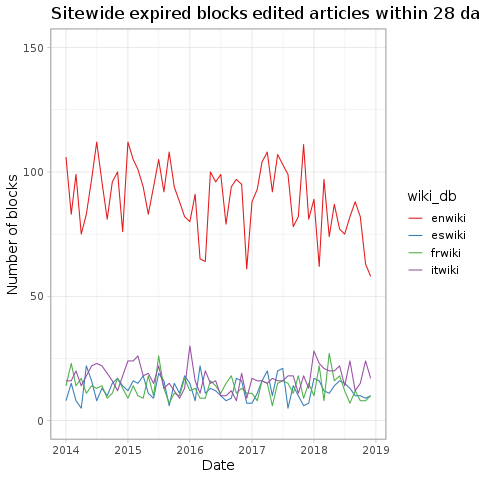

In [45]:
%%R -i sitewide_nonreverted_article_editors,start_display_date_str,truncated_end_date_str

sitewide_nonreverted_article_editors = data.table(sitewide_nonreverted_article_editors);
sitewide_nonreverted_article_editors[, log_month := as.Date(log_month)];

sitewide_nonreverted_article_editors_graph = ggplot(
    sitewide_nonreverted_article_editors[log_month >= start_display_date_str &
                                        log_month < truncated_end_date_str],
    aes(x=log_month, y=num_blocks, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 150), breaks = c(0:3)*50) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Sitewide expired blocks edited articles within 28 days',
     x = 'Date',
     y = 'Number of blocks') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/sitewide_nonreverted_article_editors_28days_per_month.png",
       plot = sitewide_nonreverted_article_editors_graph,
       width = 40, height = 20, units = "cm", dpi = "screen");
sitewide_nonreverted_article_editors_graph;

# Measurements

Since we now have measurements D, F, and G calculated, we can use those to calculate proportion of expired blocks that were not reblocked, and proportion of expired blocks that made constructive edits.

## Proportion of expired blocks not reblocked

In [46]:
## Measure: Proportion of F in D

measurement_f = pd.merge(
    sitewide_expired_blocks.rename(columns={'num_blocks':'num_expired_blocks'}),
    sitewide_not_reblocked.rename(columns={'num_blocks':'num_non_reblocked'}),
    on=['wiki_db', 'log_month'])
measurement_f['prop'] = (100 *
                         measurement_f['num_non_reblocked'] / measurement_f['num_expired_blocks'])

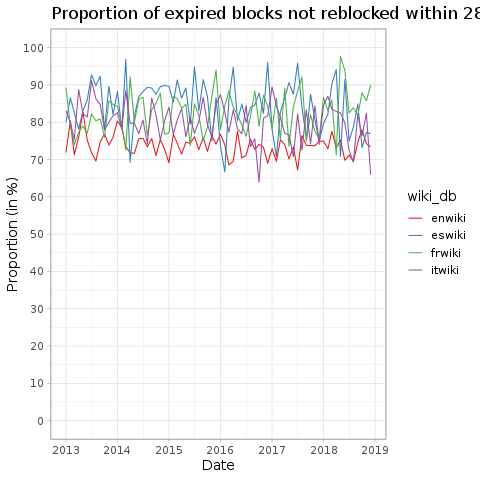

In [47]:
%%R -i measurement_f

measurement_f = data.table(measurement_f);
measurement_f[, log_month := as.Date(log_month)];

measurement_f_graph = ggplot(measurement_f,
                             aes(x=log_month, y=prop, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 100), breaks = c(0:10)*10) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Proportion of expired blocks not reblocked within 28 days',
     x = 'Date',
     y = 'Proportion (in %)') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/proportion_sitewide_blocks_not_reblocked.png",
       plot = measurement_f_graph,
       width = 40, height = 20, units = "cm", dpi = "screen");
measurement_f_graph;

## Proportion of expired blocks making constructive edits

In [53]:
## Measure: Proportion of G in D

measurement_g = pd.merge(
    sitewide_expired_blocks.rename(columns={'num_blocks':'num_expired_blocks'}),
    sitewide_nonreverted_editors.rename(columns={'num_blocks':'num_non_reverted'}),
    on=['wiki_db', 'log_month'])
measurement_g['prop'] = (100 *
                         measurement_g['num_non_reverted'] / measurement_g['num_expired_blocks'])

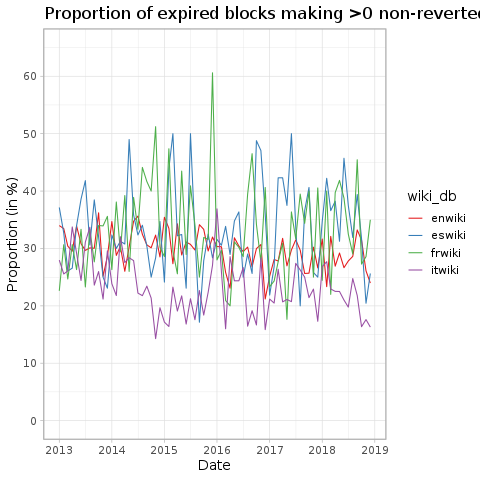

In [54]:
%%R -i measurement_g

measurement_g = data.table(measurement_g);
measurement_g[, log_month := as.Date(log_month)];

measurement_g_graph = ggplot(measurement_g,
                             aes(x=log_month, y=prop, color=wiki_db)) +
scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
scale_y_continuous(limits = c(0, 65), breaks = c(0:7)*10) +
scale_colour_brewer(palette = "Set1") +
labs(title = 'Proportion of expired blocks making >0 non-reverted edits within 28 days',
     x = 'Date',
     y = 'Proportion (in %)') +
geom_line() +
theme_light(base_size = 14);

ggsave("graphs/proportion_sitewide_blocks_non_reverted.png",
       plot = measurement_g_graph,
       width = 40, height = 20, units = "cm", dpi = "screen");
measurement_g_graph;